# Assignment 6: Attention (please!)

---

## Task 1) Thesis Title Classification

In this assignment, we'll again rely on the theses dataset and want to classify whether a thesis is bachelor or master.
Update your B.Sc. / M.Sc. thesis title classification model from the previous assignment and integrate the attention mechanism.
Therefore, implement the `dot product attention` and check how it affects the training and performance for this task.
In case you want to start fresh, we provide some boiler plate code of a base RNN classification model as well as ready-to-go data loading.
The basic setup as well as some code and steps can be reused from your solution for the RNN tasks.

### Data

Download the `theses.csv` data set from the `Supplemental Materials` in the `Files` section of our Microsoft Teams group.
This dataset consists of approx. 3,000 theses topics chosen by students in the past.
Here are some examples of the file content:

```
27.10.94;14.07.95;1995;intern;Diplom;DE;Monte Carlo-Simulation für ein gekoppeltes Round-Robin-System;
04.11.94;14.03.95;1995;intern;Diplom;DE;Implementierung eines Testüberdeckungsgrad-Analysators für RAS;
01.11.20;01.04.21;2021;intern;Bachelor;DE;Landessprachenerkennung mittels X-Vektoren und Meta-Klassifikation;
```

*In this Jupyter Notebook, we will provide the steps to solve this task and give hints via functions & comments. However, code modifications (e.g., function naming, arguments) and implementation of additional helper functions & classes are allowed. The code aims to help you get started.*

---

In [128]:
# Dependencies
import os
import re
import tqdm
import string
import numpy as np
import pandas as pd
import sklearn.metrics as sklearn_metrics
from math import sqrt
from sklearn.model_selection import train_test_split
from typing import Iterator, Optional
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### Prepare the Data

1.1 Spend some time on preparing the dataset. It may be helpful to lower-case the data and to filter for German titles. The format of the CSV-file should be:

```
Anmeldedatum;Abgabedatum;JahrAkademisch;Art;Grad;Sprache;Titel;Abstract
```

1.2 Create the vocabulary from the prepared dataset. You'll need it for the modeling part such as nn.Embedding.

1.3 Filter out all diploma theses; they might be too easy to spot because they only cover "old" topics.

1.4 Create a PyTorch Dataset class which handles your tokenized data with respect to input and (class) labels.

In [129]:
def load_theses_dataset(filepath):
    """Loads all theses instances and returns them as a dataframe."""
    ### YOUR CODE HERE
    
    return pd.read_csv(filepath, header=0, sep=";")
    
    ### END YOUR CODE

In [130]:
def tokenize(text: str) -> Iterator[str]:
    yield "<s>"
    for s in text.split():
        m = re.match(r"^(\w+)?([,\.?!])?$", s)
        if m is not None:
            if m.group(1) is not None:
                yield m.group(1).lower()
            if m.group(2) is not None:
                yield m.group(2)
    yield "</s>"

def preprocess(dataframe):
    """Preprocesses and tokenizes the given theses titles for further use."""
    ### YOUR CODE HERE
    
    def _preprocss_fn(text):
        remove_digits = str.maketrans(string.digits, ' '*len(string.digits))
        remove_pun = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        text = text.translate(remove_digits)
        text = text.translate(remove_pun)
        text = re.sub(' {2,}', ' ', text)
        return text.lower()
    
    dataframe = dataframe.copy()
    
    # Remove punctuation, digits and lowercase titles
    dataframe["Titel"] = dataframe["Titel"].apply(lambda s: _preprocss_fn(s))

    # Filter out empty and short titles
    dataframe = dataframe[dataframe["Titel"].str.len() > 4]

    # Reset index of dataframe
    dataframe = dataframe.reset_index(drop=True)

    # Simple tokenization of titles
    dataframe["tokenized"] = [list(tokenize(title)) for title in dataframe["Titel"].values]

    return dataframe

    ### END YOUR CODE

In [131]:
# Load and preprocess dataset
dataframe_all = load_theses_dataset("data/theses2022.csv")
dataframe_all = dataframe_all[dataframe_all["Sprache"] == "DE"]
dataframe_all = preprocess(dataframe_all)

# Convert labels to integer
LABEL2IDX = {"Bachelor": 0, "Master": 1, "Diplom": 2}
dataframe_all["label"] = dataframe_all["Grad"].apply(lambda l: LABEL2IDX[l])

# Filter out `Diplom`
dataframe_diplom = dataframe_all[dataframe_all["Grad"] == "Diplom"]
dataframe = dataframe_all[dataframe_all["Grad"] != "Diplom"]

# Check number of samples and label distribution
print(f"Num theses (overall): {len(dataframe_all)}")
print(f"Num theses (w/o diplom): {len(dataframe)}")
print(f"Num theses (diplom): {len(dataframe_diplom)}")
print()
print(dataframe_all["Grad"].value_counts())

Num theses (overall): 2982
Num theses (w/o diplom): 2126
Num theses (diplom): 856

Grad
Bachelor    1667
Diplom       856
Master       459
Name: count, dtype: int64


In [132]:
### Notice: Think about padding tokens for batch sizes > 1

vocab = set()
vocab.add("<pad>")

# For a more realistic application, we have to deal with unknown tokens
# that were not present in the training corpus. However, for the sake
# of clarity, we add all possible tokens from our dataset.
# vocab.add("<unk>")

# Prepare vocabulary
for s in dataframe_all.tokenized:
    vocab.update(s)

vocab_size = len(vocab)

word2idx = {w: idx for (idx, w) in enumerate(sorted(vocab))}
idx2word = {idx: w for (idx, w) in enumerate(sorted(vocab))}

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 7951


In [133]:
### PyTorch dataset for our thesis classification task

class ThesisClassificationDataset(Dataset):
    def __init__(self, dataset, labels, word2idx):
        self.data, self.labels = [], []
        for tokens, label in zip(dataset, labels):
            # Create inputs; map tokens to ids
            self.data.append(torch.stack([
                torch.tensor(word2idx[w], dtype=torch.long) for w in tokens
            ]))

            # Create labels; already an integer
            self.labels.append(label)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        # Returns one input and label sample
        return self.data[idx], self.labels[idx]

### Train and Evaluate

2.1 Implement the dot product attention mechanism and integrate it into your RNN classification model.

2.2 Train and evaluate your models with a train-test-split (or optional 5-fold cross-validation).

2.3 Assemble a table: Recall/Precision/F1 measure for RNN classification with and without attention. Do your results improve w.r.t. your old model?

2.4 Can you find certain words that receive high attention weights regarding the decision?

In [134]:
### TODO: 2.1 Implement RNN classifier (nn.Module)
### Notice: Think about padding for batch sizes > 1
### Notice: 'torch.nn.utils.rnn' provides functionality
### Notice: Here you can integrate the attention mechanism

### YOUR CODE HERE

def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, return_weights: bool = False) -> torch.Tensor | tuple[torch.Tensor, torch.Tensor]: 
    scores = torch.where(Q.isnan(), 0, Q) @ torch.where(K.isnan(), 0, Q).mT / sqrt(Q.shape[1])
    score_mask = ~K[:, :, 0:1].mT.isnan().repeat(1, scores.shape[1], 1)
    weight_mask = ~Q[:, :, 0:1].isnan().repeat(1, 1, scores.shape[2])
    weights = torch.where(
        weight_mask,
        F.softmax(torch.where(score_mask, scores, -torch.inf), 2),
        0
    )
    result = weights @ torch.where(V.isnan(), 0, V)
    if return_weights:
        return result, weights
    else:
        return result
    
class AttentionHead(nn.Module):
    def __init__(self, d_q_in: int, d_kv_in: int, d_qk: int, d_v: int, **kwargs):
        super(AttentionHead, self).__init__(**kwargs)
        self.Wq = nn.Linear(d_q_in, d_qk)
        self.Wk = nn.Linear(d_kv_in, d_qk)
        self.Wv = nn.Linear(d_kv_in, d_v)

    def forward(self, Q: torch.Tensor, KV: torch.Tensor, return_weights: bool = False) -> torch.Tensor | tuple[torch.Tensor, torch.Tensor]:
        return scaled_dot_product_attention(
            AttentionHead.__apply_linear_masked(self.Wq, Q),
            AttentionHead.__apply_linear_masked(self.Wk, KV),
            AttentionHead.__apply_linear_masked(self.Wv, KV),
            True
        )
    
    @staticmethod
    def __apply_linear_masked( linear: nn.Linear, X: torch.Tensor) -> torch.Tensor:
        mask = ~X[:, :, 0:1].isnan().repeat(1, 1, linear.out_features)
        return torch.where(
            mask,
            linear(torch.where(X.isnan(), 0, X)),
            torch.nan
        )        

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, PackedSequence

class GRU_Classifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_classes,
                 with_attention=False):
        super(GRU_Classifier, self).__init__()
        self.with_attention = with_attention

        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim
        )

        if self.with_attention:
            self.attention_head = AttentionHead(hidden_dim, hidden_dim, hidden_dim, hidden_dim)

        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            bidirectional=False,
            num_layers=1
        )

        self.fc = nn.Linear(hidden_dim, num_classes)

    
    def forward(self, X, lengths, hidden=None):
        embeddings = self.embedding(X)

        # Packed squence helps avoid unneccsary computation
        packed_seq = pack_padded_sequence(embeddings, lengths)

        outputs, hidden_states = self.rnn(packed_seq , hidden)

        # If tuple (h_n, c_n) containts cell state c_n then select h_n
        if isinstance(hidden_states, tuple):
            hidden = hidden_states[0]
        else:
            hidden = hidden_states

        if self.with_attention:
            H = self.get_attention_input(outputs)
            attention_out, weights = self.attention_head(H, H, True)
            clf_input = attention_out[:, 0, :]
        else:
            clf_input, weights = hidden, None

        # Apply classifier with hidden states
        logits = self.fc(clf_input.squeeze(0))
        if len(logits.shape) == 1:
            logits = logits.reshape(1, -1)

        return logits, hidden_states, weights
    
    def get_attention_input(self, X: PackedSequence) -> torch.Tensor:
        result = torch.full((int(X.batch_sizes[0]), X.batch_sizes.shape[0], X.data.shape[1]), torch.nan, dtype=X.data.dtype, device=X.data.device)
        start = 0
        for i, size in enumerate(X.batch_sizes):
            stop = start + size
            result[:size, i, :] = X.data[start:stop, :]
            start = stop
        return result


class SequencePadder():
    def __init__(self, symbol) -> None:
        self.symbol = symbol

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        sequences = [x[0] for x in sorted_batch]
        labels = [x[1] for x in sorted_batch]
        padded = pad_sequence(sequences, padding_value=self.symbol)
        lengths = torch.LongTensor([len(x) for x in sequences])
        return padded, torch.LongTensor(labels), lengths


### END YOUR CODE

In [135]:
### TODO: 2.2 Implement the train functionality

### YOUR CODE HERE

from typing import Callable


def train(model: nn.Module, dataloader: DataLoader, criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], optimizer: optim.Optimizer, device: torch.device):
    batch_count = len(dataloader)
    running_loss = 0.0
    for i, (X, Y, lengths) in enumerate(dataloader):
        X = X.to(device)
        Y = Y.to(device)
        print(f"\r  training batch {i+1}/{batch_count}", end="")
        optimizer.zero_grad()
        logits, _, _ = model(X, lengths)
        loss = criterion(logits, Y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print()
    print(f"  average loss: {running_loss/batch_count}")

### END YOUR CODE

In [136]:
### TODO: 2.2 Implement the evaluation functionality

### YOUR CODE HERE

def eval(model: nn.Module, dataloader: DataLoader, criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], device: torch.device, return_attn_dict=False) -> Optional[torch.Tensor]:
    batch_count = len(dataloader)
    running_loss = 0.0
    Y_pred = []
    Y_true = []
    attention_scores = []
    with torch.no_grad():
        for i, (X, Y, lengths) in enumerate(dataloader):
            X = X.to(device)
            Y = Y.to(device)
            print(f"\r  evaluating batch {i+1}/{batch_count}", end="")
            logits, _, weights = model(X, lengths)
            running_loss += criterion(logits, Y).item()
            for y in torch.argmax(logits, 1).tolist():
                Y_pred.append(y)
            for y in Y.tolist():
                Y_true.append(y)
            if return_attn_dict: attention_scores.append(weights.to("cpu"))
    C = sklearn_metrics.confusion_matrix(Y_true, Y_pred)
    acc = (C.diagonal().sum() / C.sum())
    prec = (C.diagonal() / (C.sum(0) + 1e-128))
    rec = (C.diagonal() / (C.sum(1) + 1e-128))
    f1 = 2 / ((1 / (prec + 1e-128)) + (1 / (rec + 1e-128)) + 1e-128)
    print(f"  average loss:     {running_loss/batch_count}")
    print(f"  accuracy:         {acc.item()}")
    print(f"  precision scores: {prec.tolist()}")
    print(f"  recall scores:    {rec.tolist()}")
    print(f"  F1 scores:        {f1.tolist()}")
    if return_attn_dict:
        max_len = max(x.shape[1] for x in attention_scores)
        return torch.cat([
            torch.hstack([
                scores[:, 0, :],
                torch.zeros((scores.shape[0], max_len - scores.shape[2]), dtype=scores.dtype)
            ])
            for scores in attention_scores
        ], 0)

### END YOUR CODE

In [137]:
### TODO: 2.3 Initialize and train the RNN Classification Model for X epochs + Evaluation

# Training parameters
SEED = 42
EPOCHS = 30
BATCH_SIZE = 256

LEARNING_RATE = 0.001

DEVICE = "cuda:0" # 'cpu', 'mps' or 'cuda'
LABEL_COL = "label"
PAD_IDX = word2idx["<pad>"]

TEST_RATIO = 0.2

EMBEDDING_DIM = 64
HIDDEN_LAYER_SIZE = 32

### YOUR CODE HERE

data_samples = dataframe["tokenized"].values
data_labels = dataframe[LABEL_COL].values
train_idcs, test_idcs = train_test_split(list(range(len(data_samples))), random_state=SEED)
dataset_train = ThesisClassificationDataset([data_samples[i] for i in train_idcs], [data_labels[i] for i in train_idcs], word2idx=word2idx)
dataset_test = ThesisClassificationDataset([data_samples[i] for i in test_idcs], [data_labels[i] for i in test_idcs], word2idx=word2idx)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, collate_fn=SequencePadder(PAD_IDX))
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=SequencePadder(PAD_IDX))

print("###########################")
print("# Model without attention #")
print("###########################\n")

model_without_attention = GRU_Classifier(vocab_size, EMBEDDING_DIM, HIDDEN_LAYER_SIZE, 2).to(DEVICE)

criterion = nn.CrossEntropyLoss(torch.tensor([0.2, 0.8])).to(DEVICE)

optimizer = optim.Adam(model_without_attention.parameters(), LEARNING_RATE)

for e in range(EPOCHS):
    print(f"training epoch {e+1}/{EPOCHS}...")
    train(model_without_attention, dataloader_train, criterion, optimizer, torch.device(DEVICE))

print("evaluating model...")
eval(model_without_attention, dataloader_test, criterion, torch.device(DEVICE))
print()


print("########################")
print("# Model with attention #")
print("########################\n")

model_with_attention = GRU_Classifier(vocab_size, EMBEDDING_DIM, HIDDEN_LAYER_SIZE, 2, True).to(DEVICE)

criterion = nn.CrossEntropyLoss(torch.tensor([0.2, 0.8])).to(DEVICE)

optimizer = optim.Adam(model_with_attention.parameters(), LEARNING_RATE)

for e in range(EPOCHS):
    print(f"training epoch {e+1}/{EPOCHS}...")
    train(model_with_attention, dataloader_train, criterion, optimizer, torch.device(DEVICE))

print("evaluating model...")
attention_scores: torch.Tensor = eval(model_with_attention, dataloader_test, criterion, torch.device(DEVICE), True) # type: ignore

### END YOUR CODE

###########################
# Model without attention #
###########################

training epoch 1/30...
  training batch 7/7
  average loss: 0.7055126598903111
training epoch 2/30...
  training batch 7/7
  average loss: 0.6931339246886117
training epoch 3/30...
  training batch 7/7
  average loss: 0.6855323399816241
training epoch 4/30...
  training batch 7/7
  average loss: 0.6821567501340594
training epoch 5/30...
  training batch 7/7
  average loss: 0.6772583382470267
training epoch 6/30...
  training batch 7/7
  average loss: 0.6710763488497052
training epoch 7/30...
  training batch 7/7
  average loss: 0.6636531097548348
training epoch 8/30...
  training batch 7/7
  average loss: 0.6549916607992989
training epoch 9/30...
  training batch 7/7
  average loss: 0.643814640385764
training epoch 10/30...
  training batch 7/7
  average loss: 0.6291816064289638
training epoch 11/30...
  training batch 7/7
  average loss: 0.6107341732297625
training epoch 12/30...
  training batch 7/7


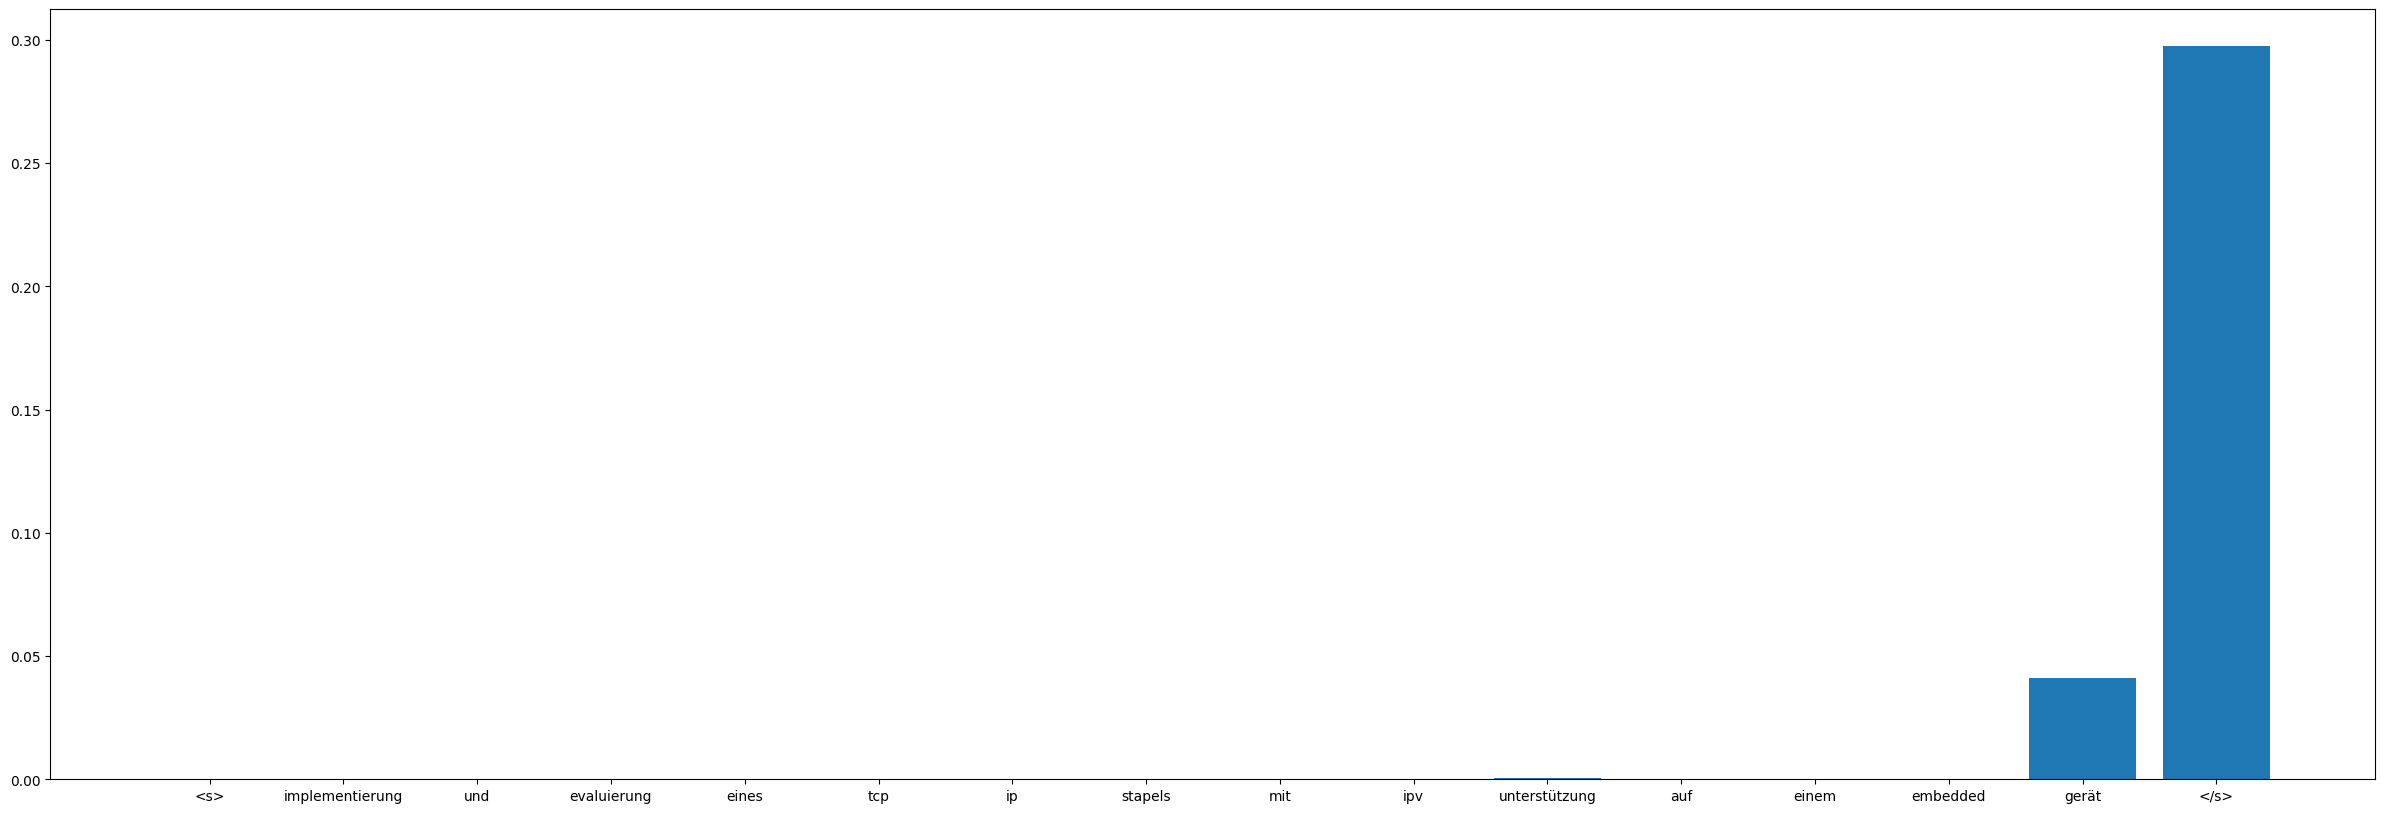

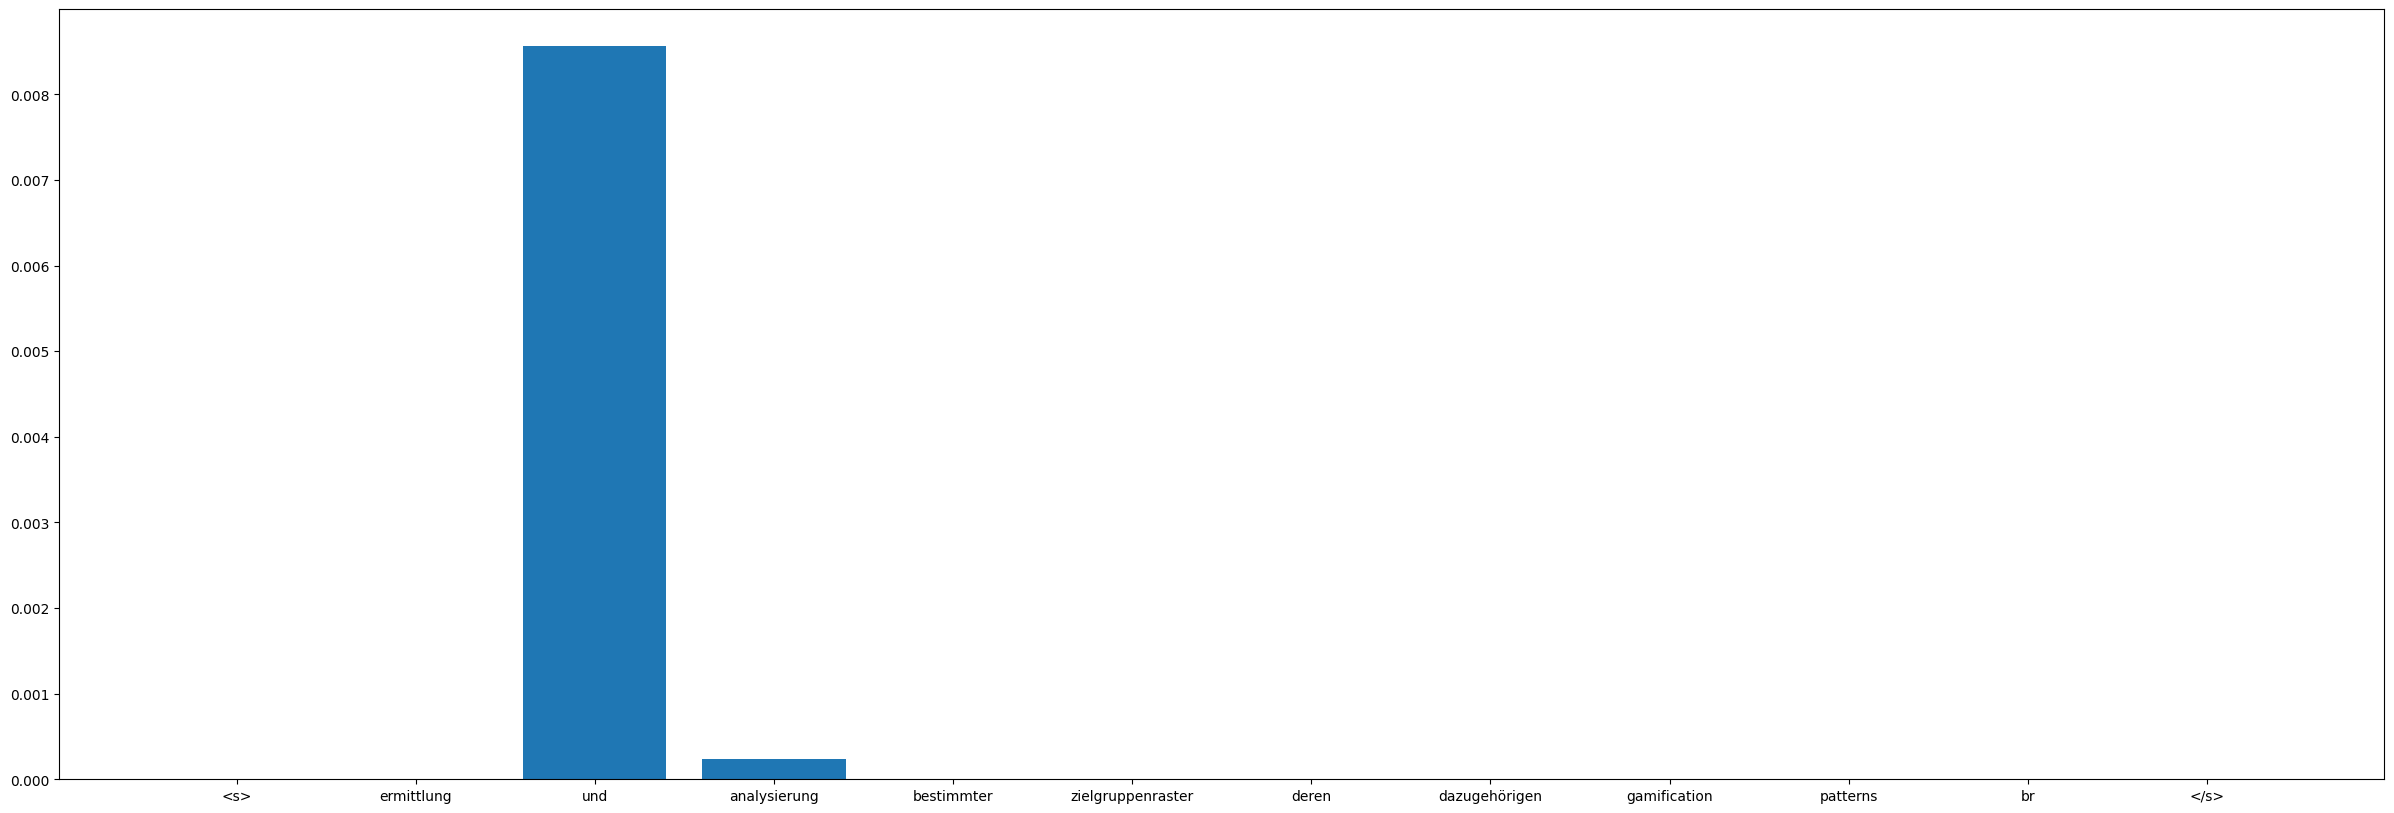

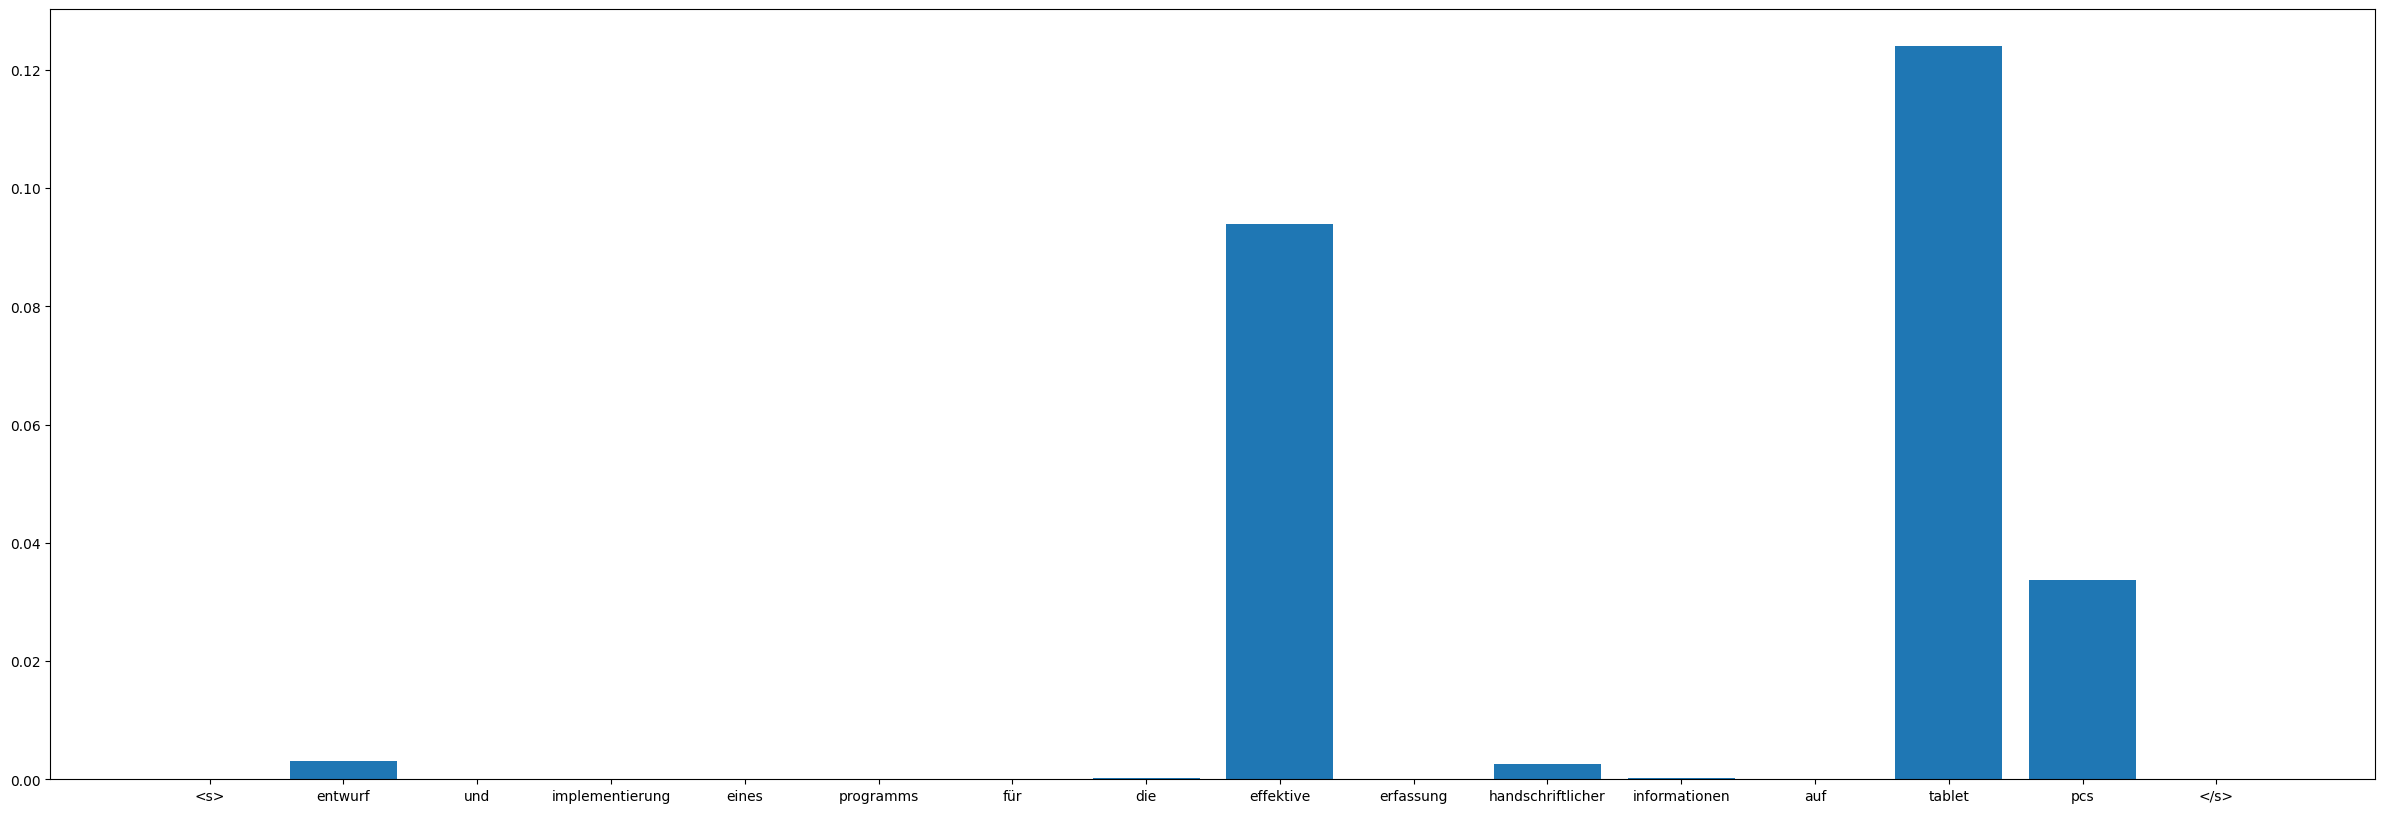

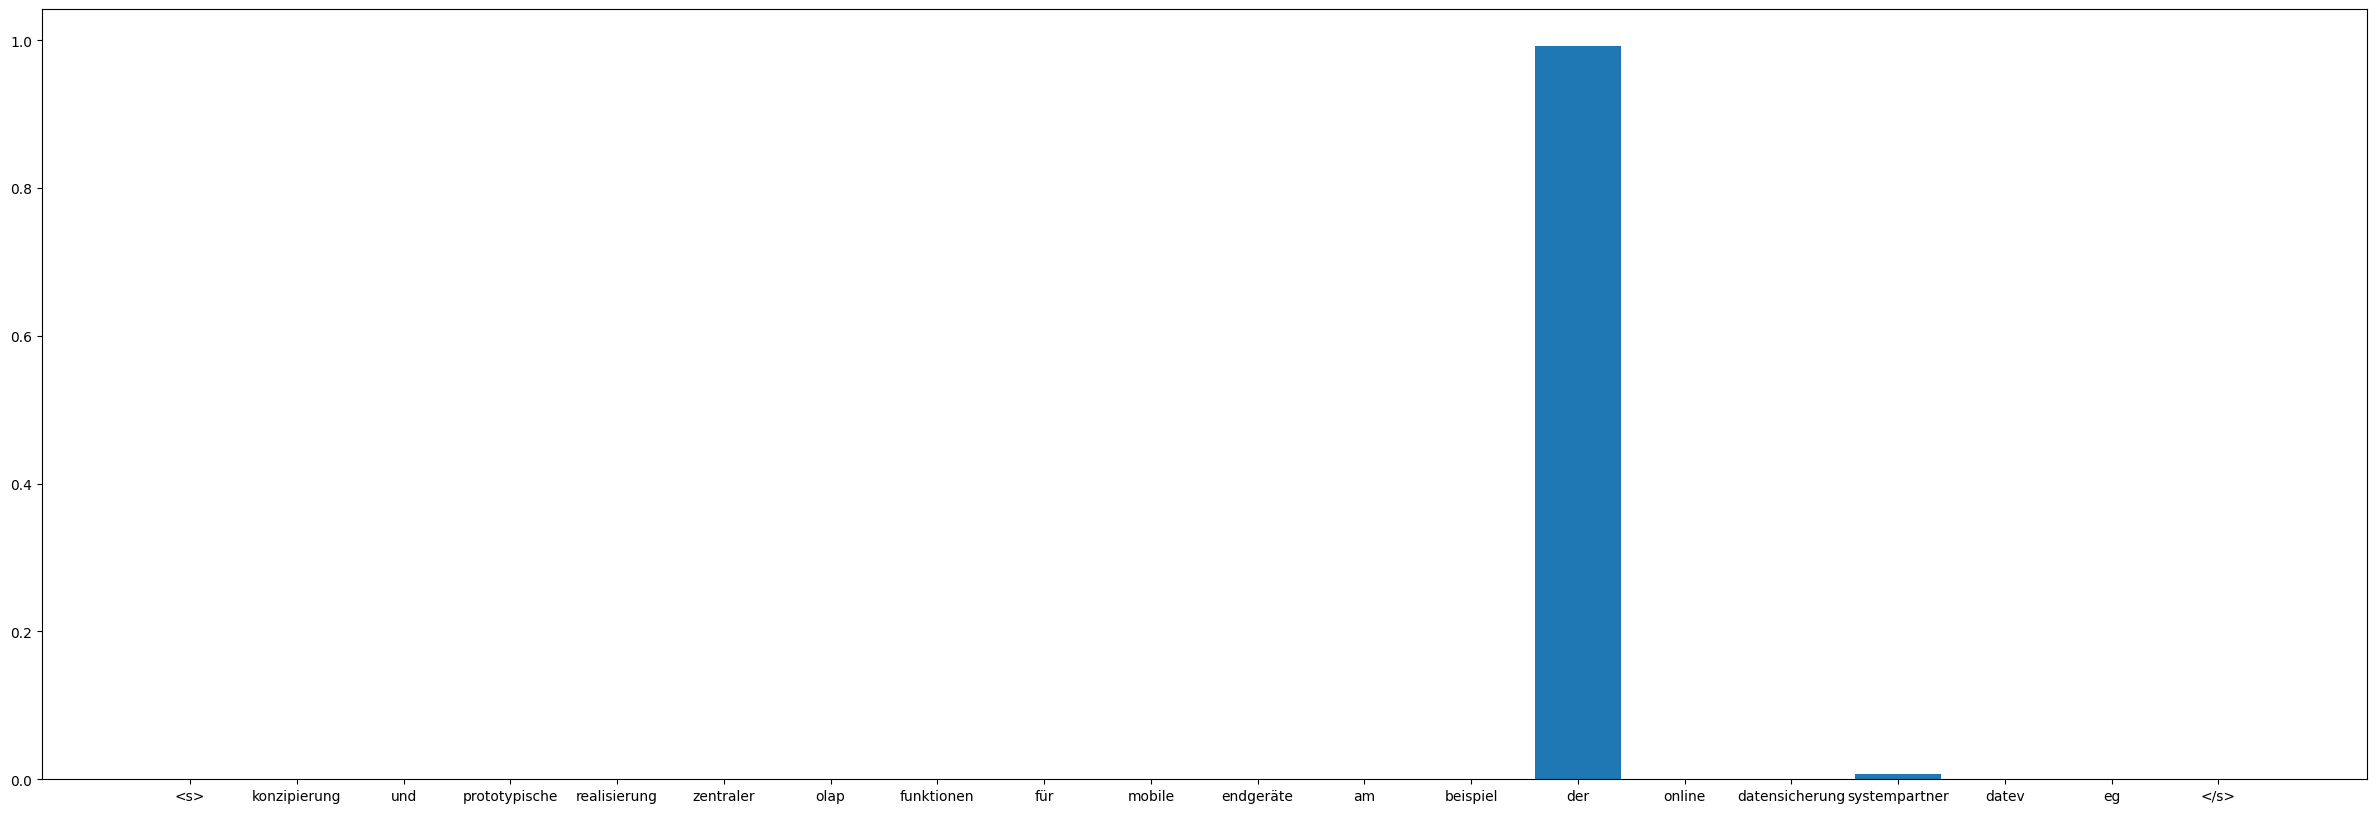

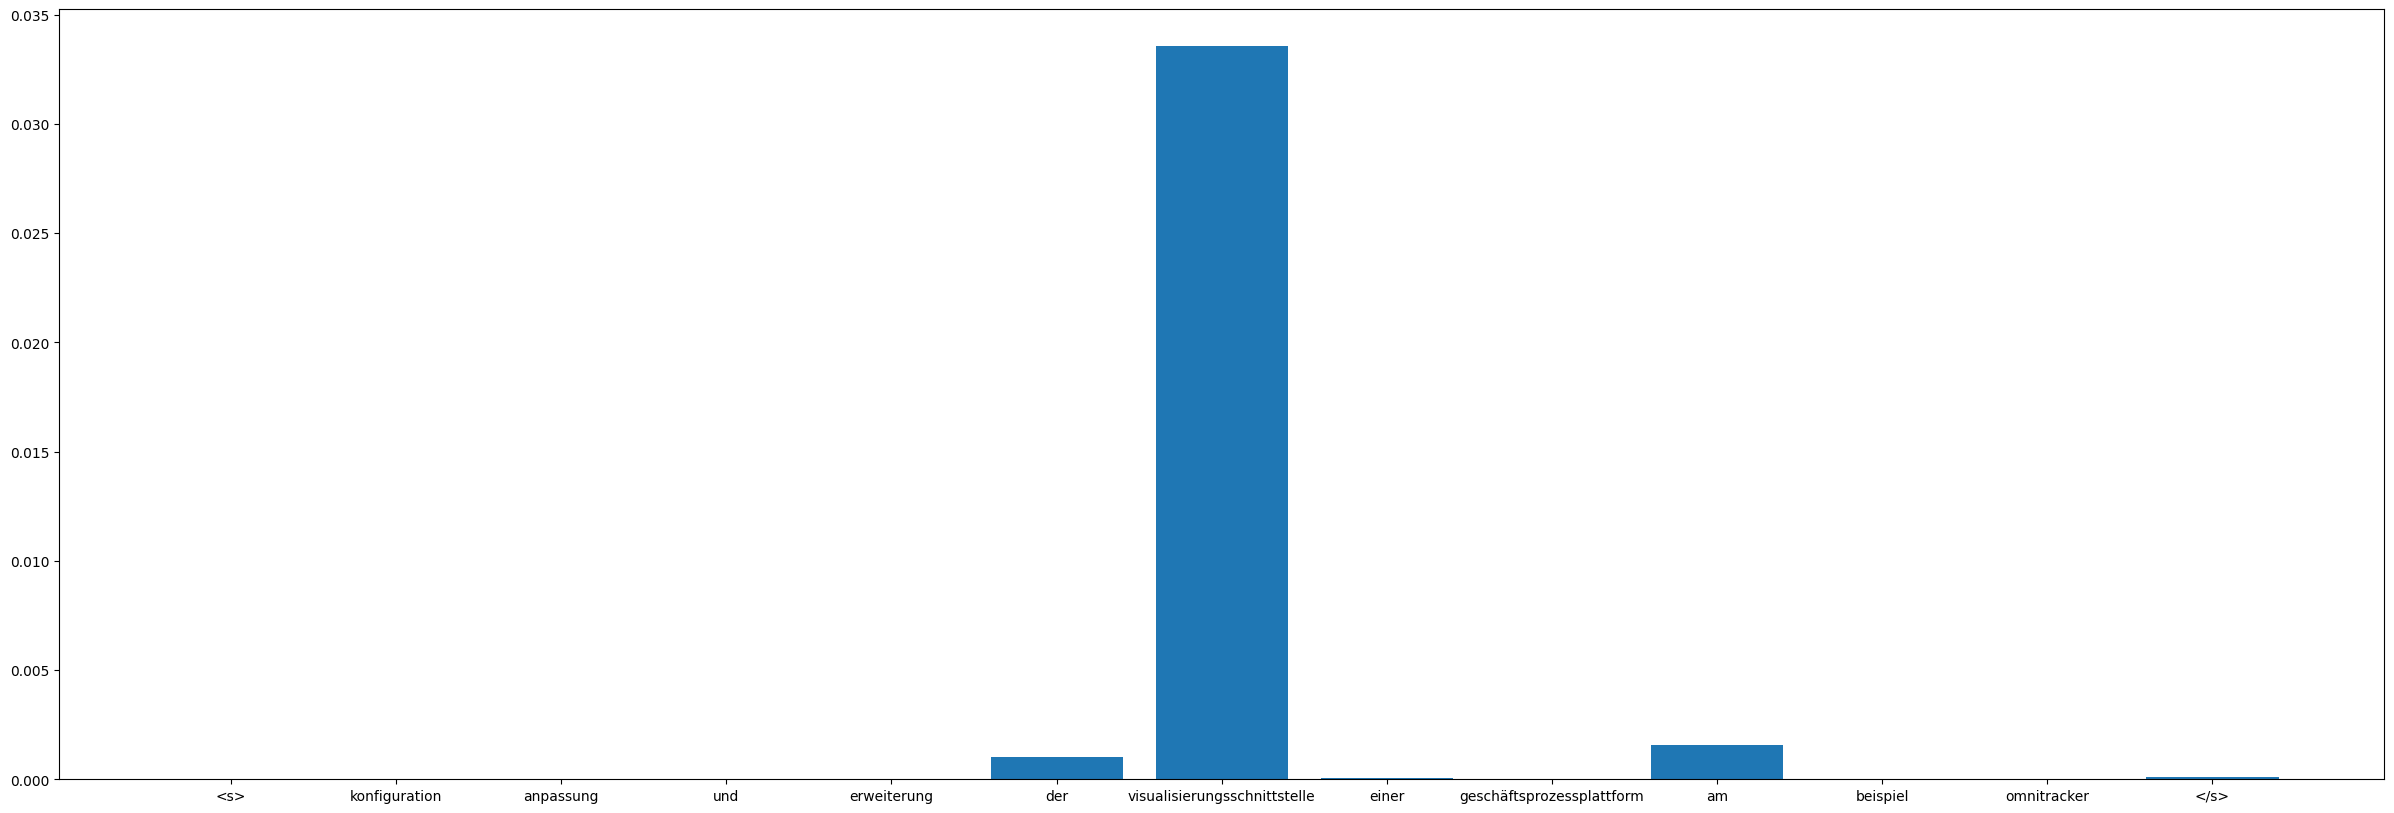

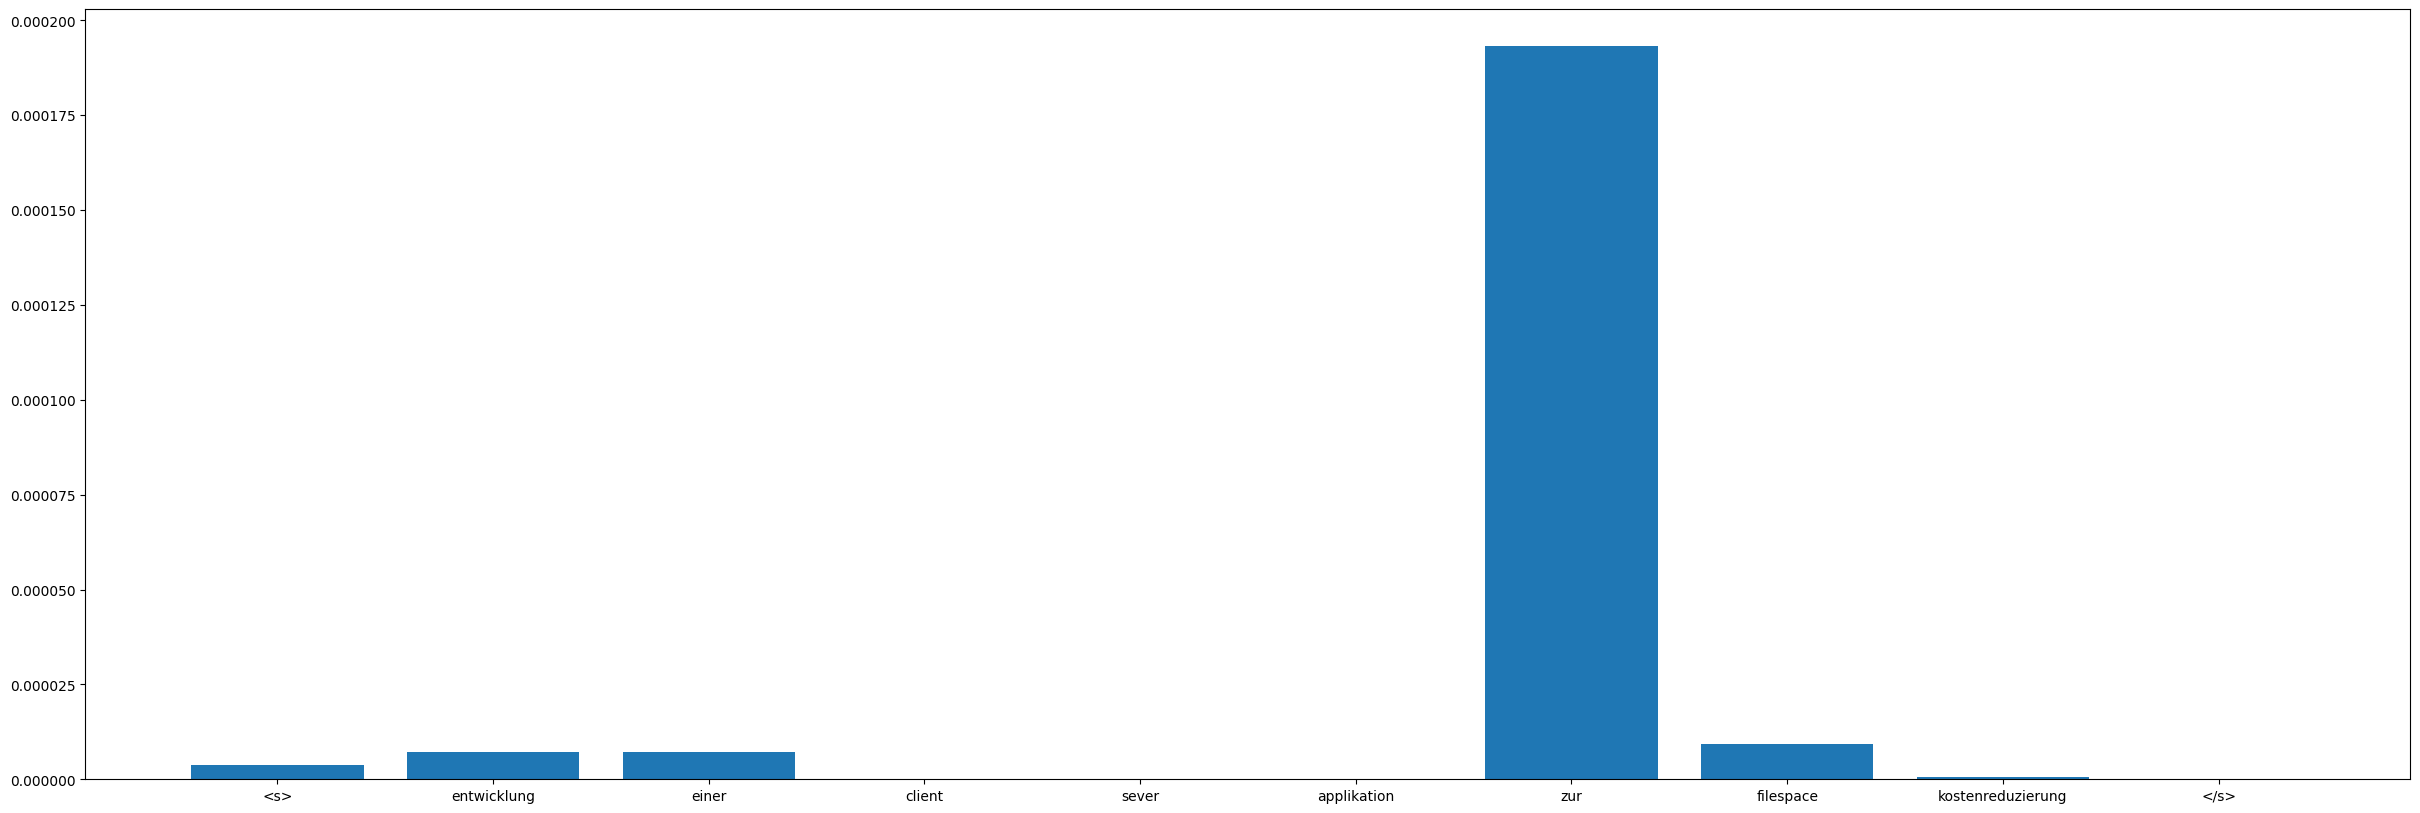

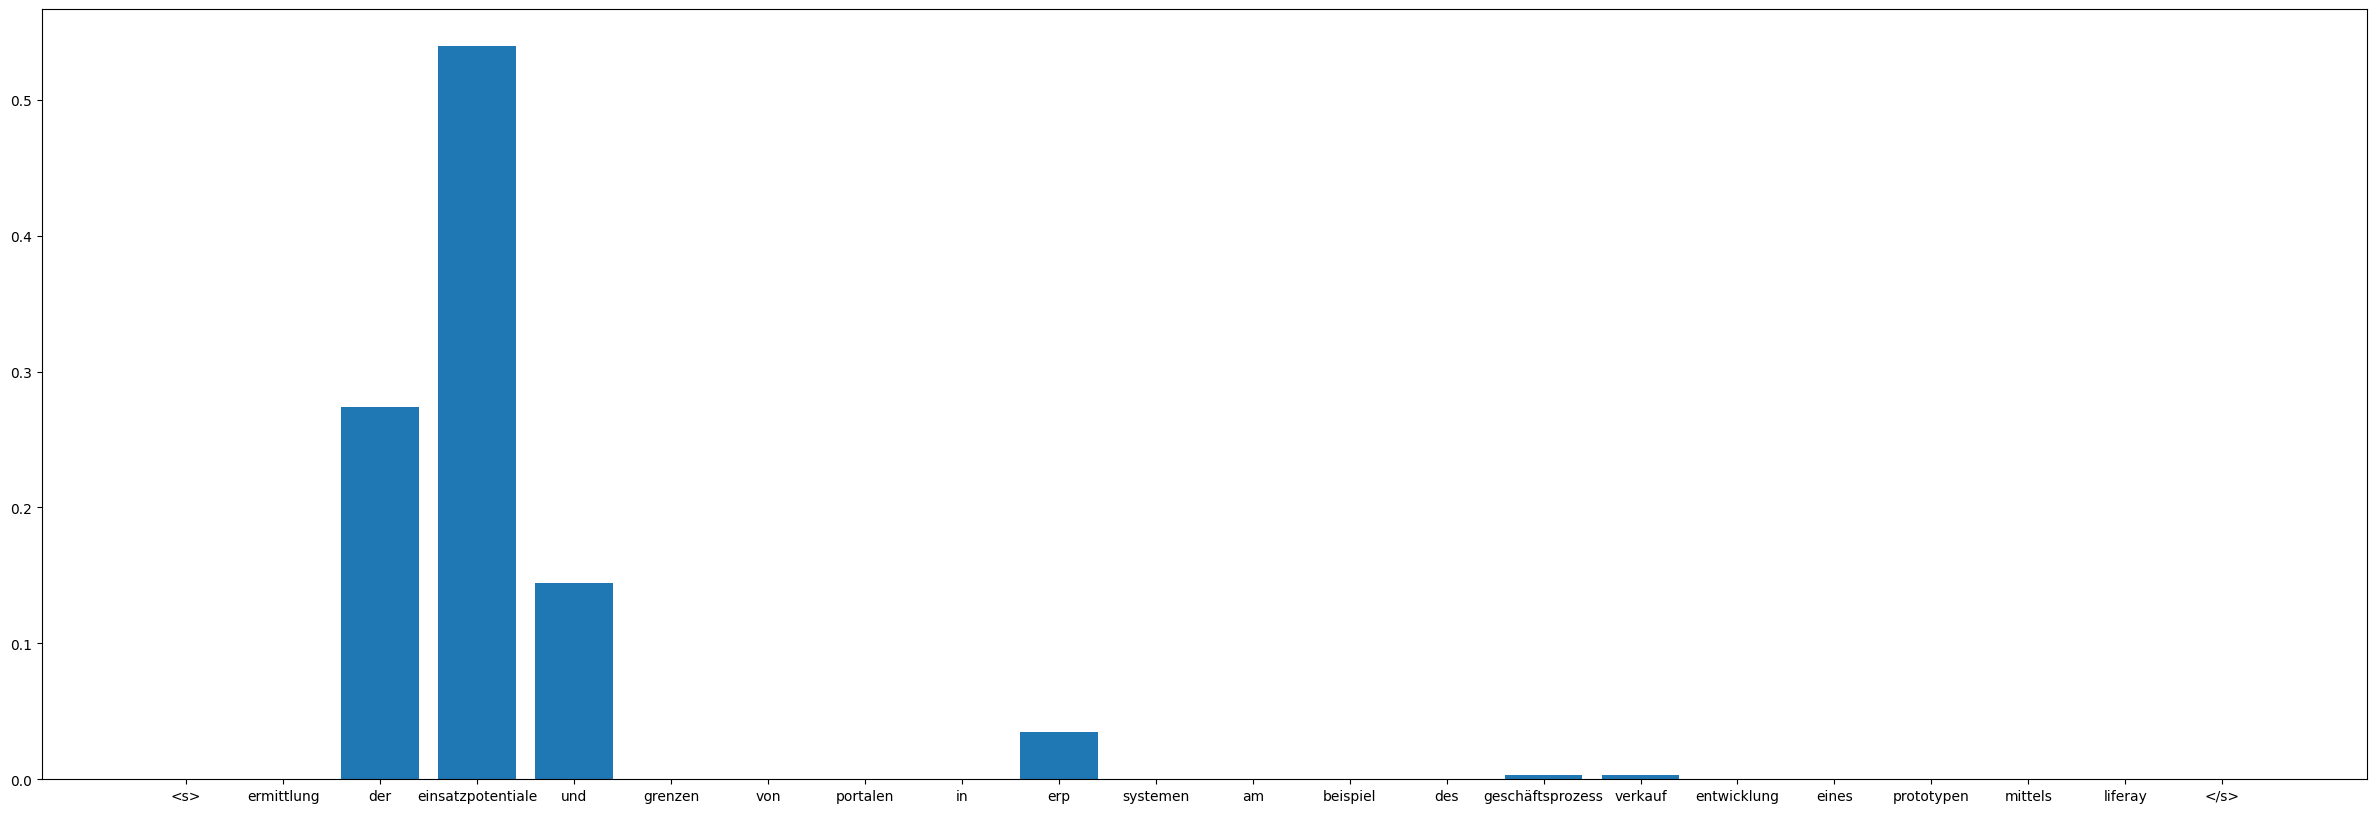

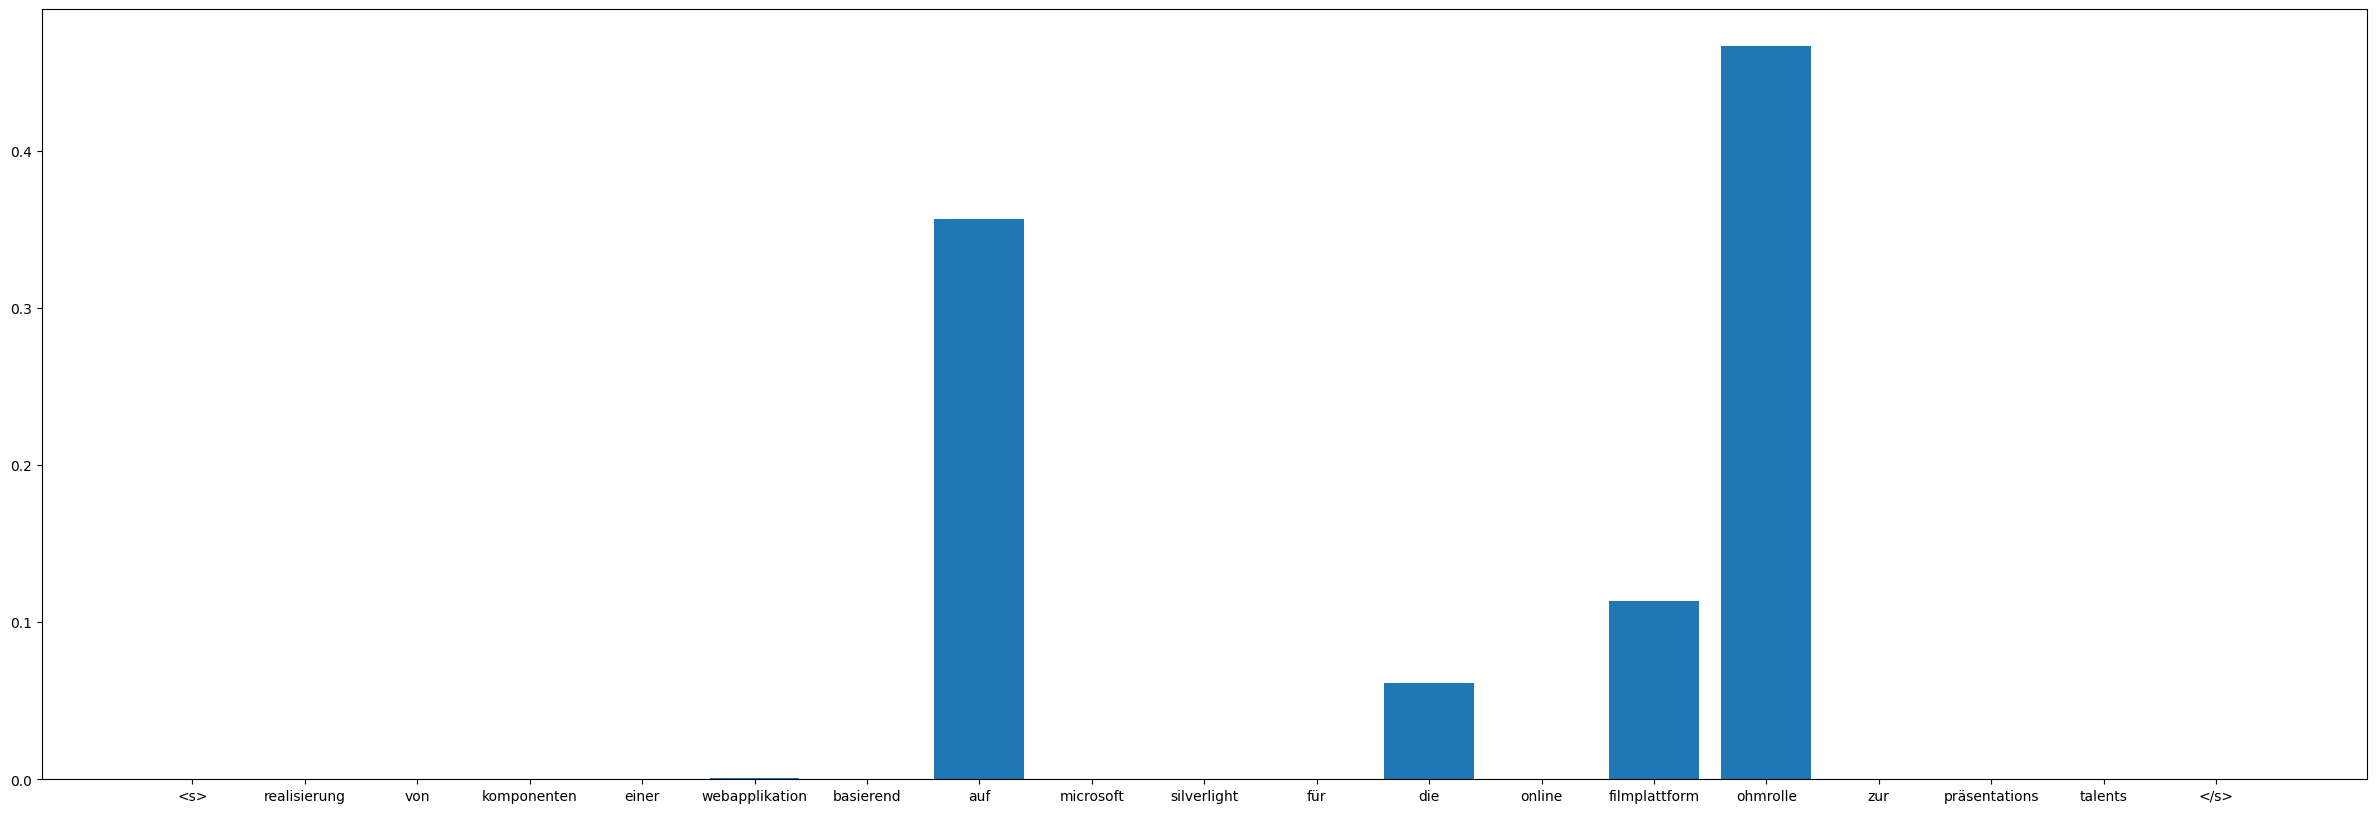

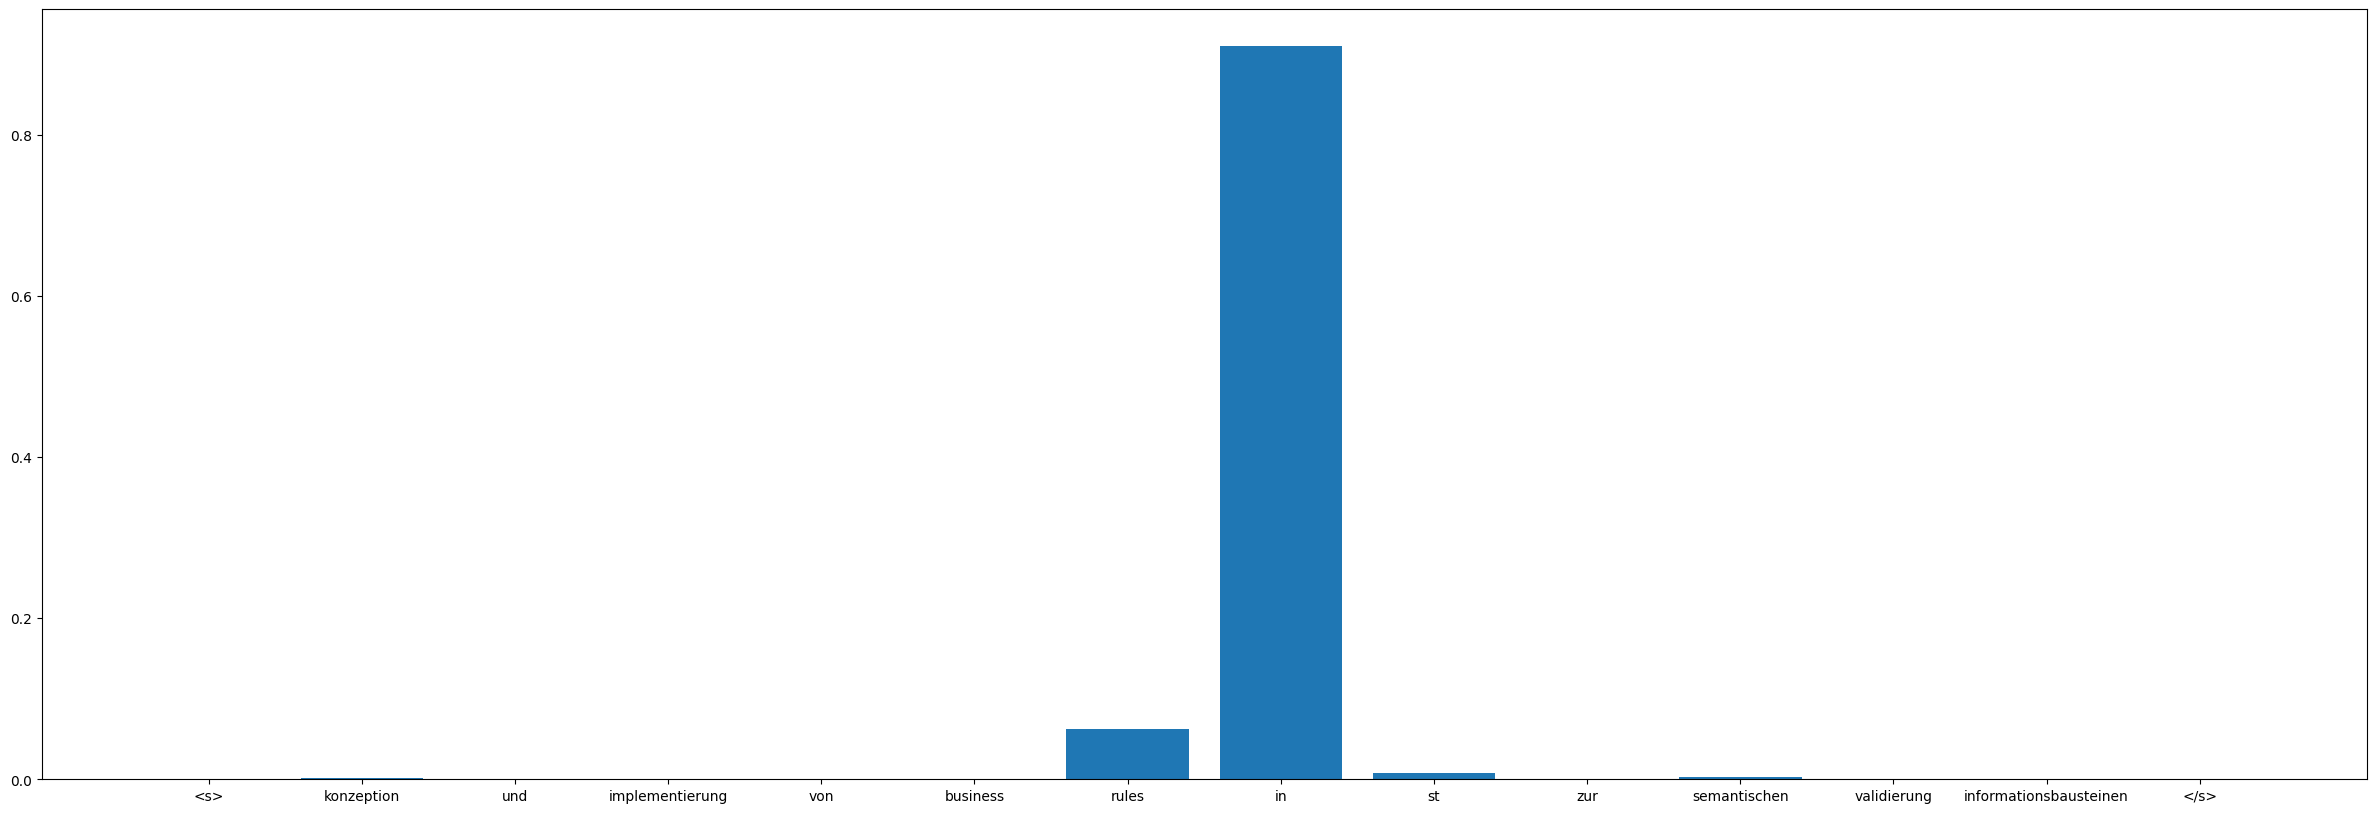

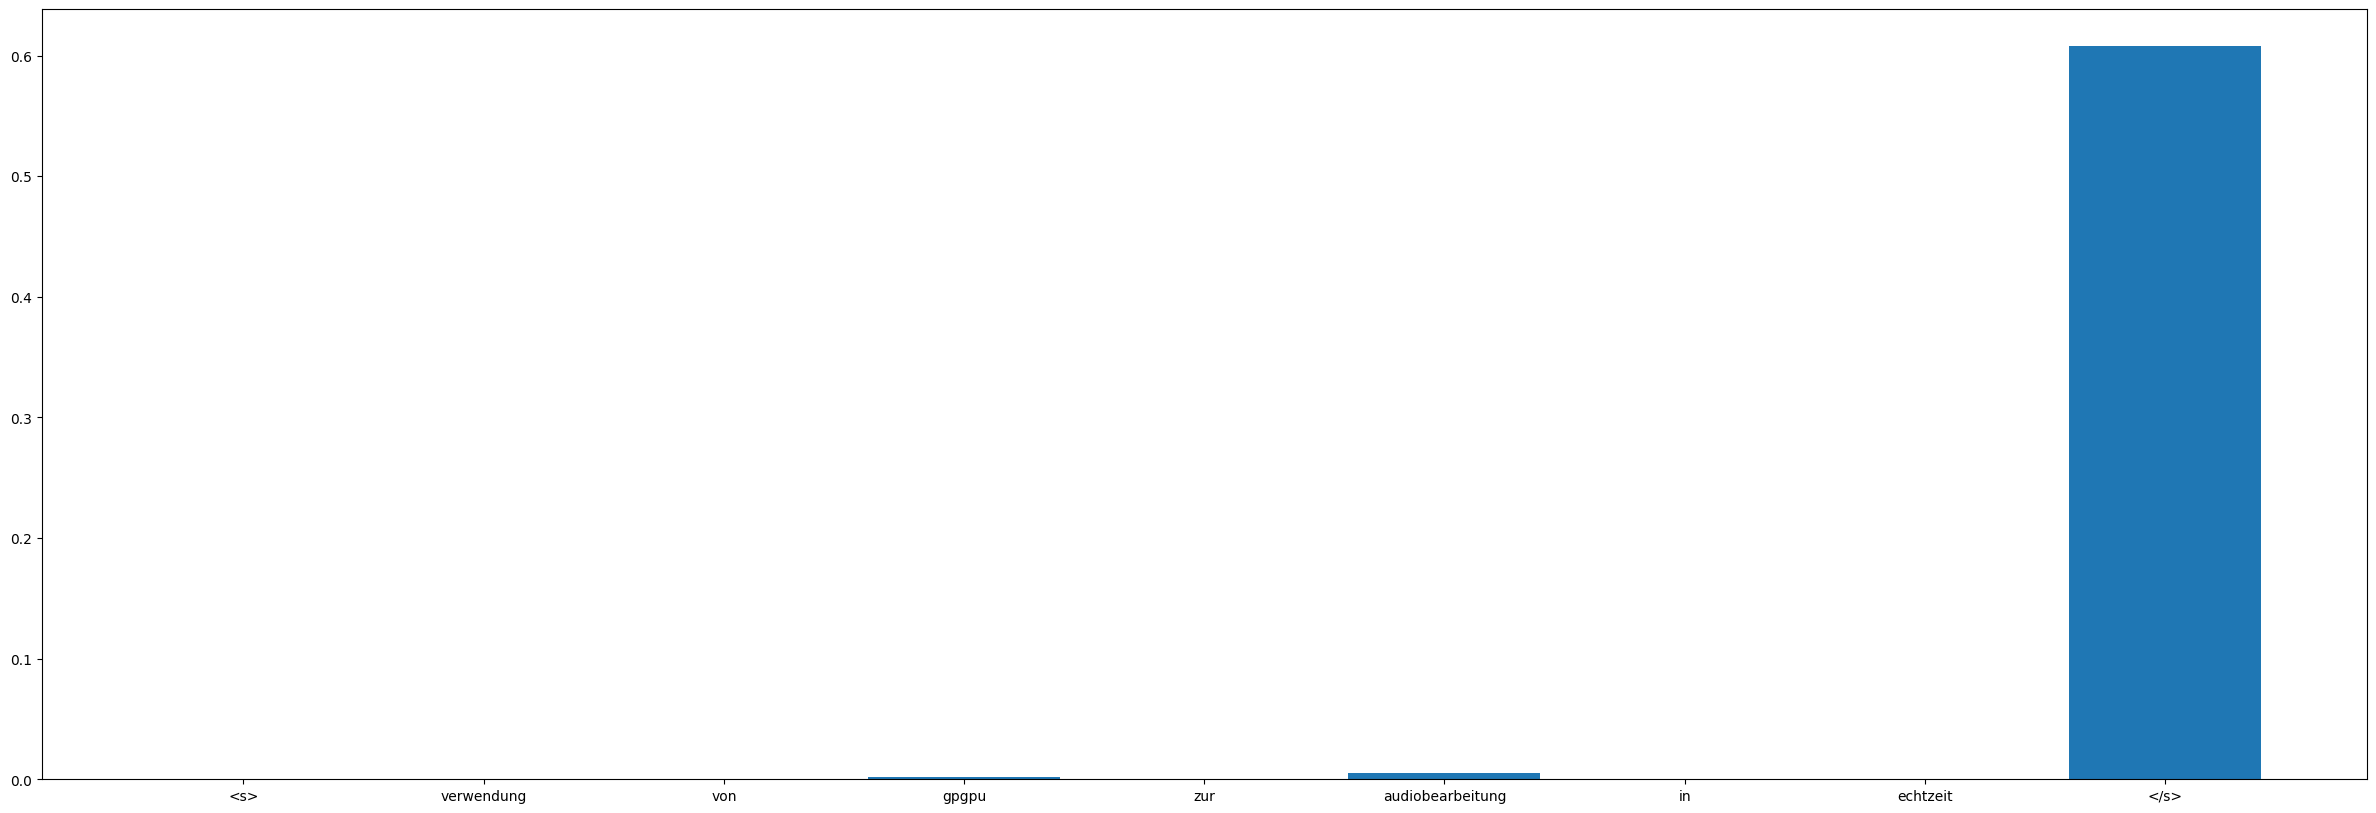

In [143]:
### TODO: 2.4 Visualize the attention weights

### YOUR CODE HERE

NUM_VISUALISATIONS = 10

for i in range(NUM_VISUALISATIONS):
    text = data_samples[train_idcs[i]]
    scores = attention_scores[i, :len(text)]
    plt.figure(figsize=(30, 10))
    plt.bar(text, scores.numpy())
    plt.show()

### END YOUR CODE